# Notebook to Investigate LSTM Performance Variance by Huc Type - Assemble Metrics And Data for MultiHuc (MandMRun)

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.datapipe import data_utils as du
from snowML.datapipe import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
# create a dictionary of run_ids 
run_dict = {"MandM_90lookback": "6b32ba5bb8714408a67c7667ce4f9a99", 
            "Mar_90lookback": "d531a38ac9d641158e2ef51870475150", 
           "Mar_90lookback_30": "7647deab6c894c1689238706a916c0ea"}
print(run_dict)

{'MandM_90lookback': '6b32ba5bb8714408a67c7667ce4f9a99', 'Mar_90lookback': 'd531a38ac9d641158e2ef51870475150', 'Mar_90lookback_30': '7647deab6c894c1689238706a916c0ea'}


In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


# Step 2 - Functions to Summarize Metrics 

In [5]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [6]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

# Step 3 - Define Some Plotting Functions

In [7]:
def plot_step_metrics(df, title='Metrics vs Step', save = True):
    """Plots all columns in the given DataFrame against the index with a legend."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each column
    for column in df.columns:
        plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/ModelChoice/{title}.png", bbox_inches='tight')
    
    plt.show()


In [8]:
def plot_median_comparison(df_dict, title="Median_Metric_Comparison_By_Epoch_And_Run", save = True):
    """Plots the 'median' column against the index for each DataFrame in the dictionary."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each DataFrame
    for label, df in df_dict.items():
        plt.plot(df.index, df['median'], marker='o', linestyle='-', label=label)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Median Value')
    plt.title(title)
    plt.ylim(-1, 1)  # Set fixed y-axis range
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/ModelChoice/{title}.png", bbox_inches='tight')

    plt.show()

# Step 4 Extract Median Test-KGE For An Exmaple Run 

In [9]:
# Recompute median from raw metrics and hope it's the same :) 
df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
summary = df_filtered.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
summary

,median,mean,min,max,std
Step,,,,,
0,0.543810,0.277775,-2.606673,0.970060,0.851513
1,0.679717,0.634406,-0.099230,0.910841,0.228368
2,0.736584,0.723767,0.177707,0.964658,0.189987
3,0.700443,0.588954,-0.942723,0.956888,0.451329
4,0.747137,0.655894,-0.590447,0.962972,0.366649
5,0.773503,0.689659,-0.390513,0.961943,0.306865
6,0.791610,0.707269,-0.068891,0.973006,0.242795
7,0.626962,0.432542,-1.809358,0.954116,0.687424
8,0.653829,0.478313,-1.493006,0.973869,0.597286


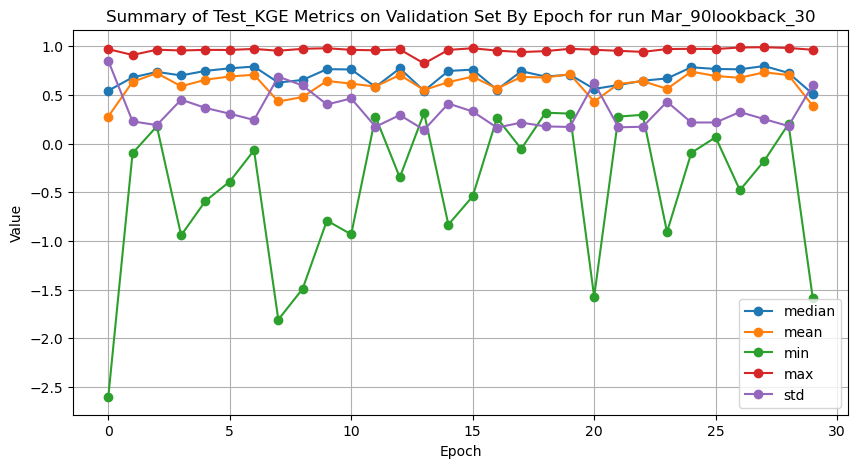

In [10]:
ttl = f"Summary of Test_KGE Metrics on Validation Set By Epoch for run {key}"
plot_step_metrics(summary, title = ttl, save = False)

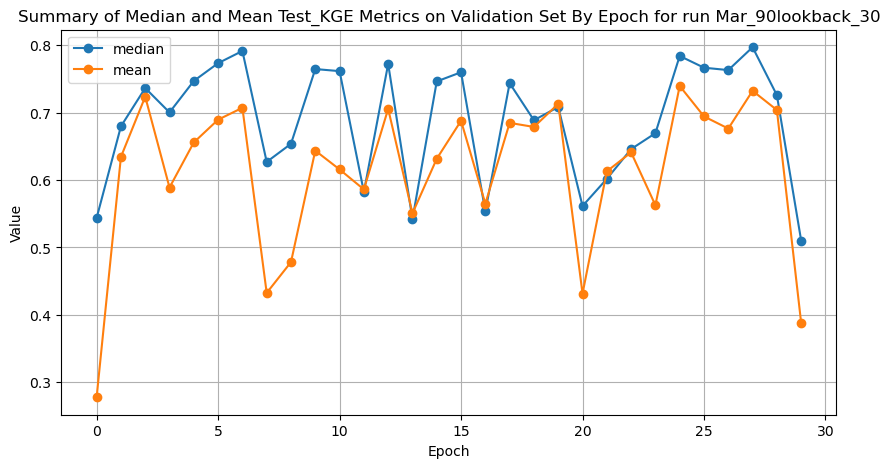

In [11]:
# zoom in on just the median and the mean
ttl = f"Summary of Median and Mean Test_KGE Metrics on Validation Set By Epoch for run {key}" 
summary_slim = summary[["median", "mean"]]
plot_step_metrics(summary_slim, title = ttl)

# Step 5 Create a Dictionary of Median_Test_KGE, by epoch, for each run 

In [12]:
df_summary_dict = {}
for key in run_dict.keys(): 
    df_metrics = df_dict[key]
    df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
    summary_df = df_filtered.groupby("Step")["Value"].agg(["median"])
    df_summary_dict[key] = summary_df


In [13]:
# extract one of the summary dfs as an example
key = "Mar_90lookback"
df_summary = df_summary_dict[key]
df_summary.head(2)

,median
Step,
0,0.754562
1,0.733313


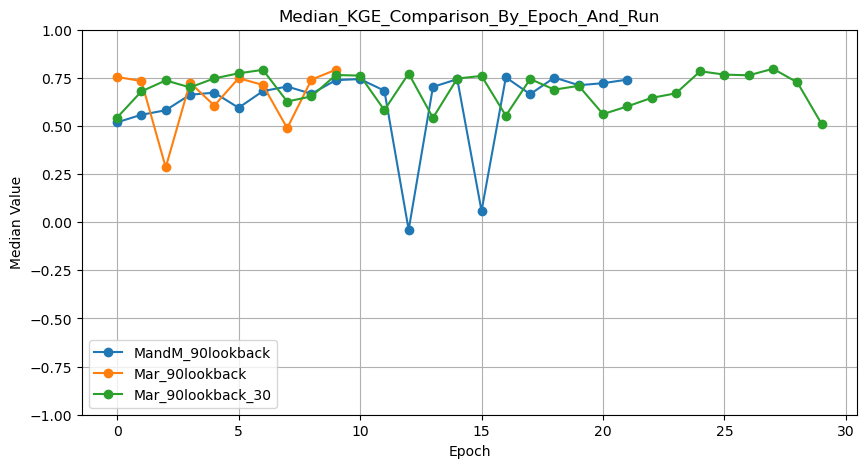

In [14]:
plot_median_comparison(df_summary_dict, title="Median_KGE_Comparison_By_Epoch_And_Run", save = False)

Lets focus on a single variable combo at a time and see how differences in training rates impact

In [15]:
keys_base = ["base_1e-3", "base_3e-4"]
keys_hum = ["hum_1e-3", "hum_3e-4"]
keys_srad = ["srad_1e-3", "srad_3e-4"]
keys_vs = ["vs_1e-3", "vs_3e-4"]

In [16]:
def learning_rate_plot(key_list, vars_desc):
    ttl = f"Median_KGE_Comparison_By_Epoch_And_Learning_Rate_{vars_desc}"
    df_dict = {key: df_summary_dict[key] for key in key_list}
    plot_median_comparison(df_dict, ttl)

In [17]:
learning_rate_plot(keys_base, "Base_Model")

KeyError: 'base_1e-3'

In [ ]:
learning_rate_plot(keys_hum, "Base_Model_Plus_Humidity")

In [ ]:
learning_rate_plot(keys_srad, "Base_Model_Plus_Solar_Radiation")

In [ ]:
learning_rate_plot(keys_vs, "Base_Model_Plus_Wind_Speed")

Now lets focus on a single training rate at a time to see how different variable combos impact 

In [ ]:
keys_1e3 = ["base_1e-3", "hum_1e-3", "srad_1e-3", "vs_1e-3"]
keys_3e4 = ["base_3e-4", "hum_3e-4", "srad_3e-4", "vs_3e-4"]

In [ ]:
def learning_rate_plot(key_list, lr_desc):
    ttl = f"Median_KGE_Comparison_By_Variable_Combo_Using_{lr_desc}"
    df_dict = {key: df_summary_dict[key] for key in key_list}
    plot_median_comparison(df_dict, ttl)

In [ ]:
def learning_rate_plot_n_to_m(key_list, lr_desc, n, m):
    ttl = f"Median_KGE_Comparison_By_Variable_Combo_Using_{lr_desc}"
    df_dict = {key: df_summary_dict[key].iloc[n:m, : ] for key in key_list}
    plot_median_comparison(df_dict, ttl, save = False)

In [ ]:
learning_rate_plot(keys_1e3, "Learning_Rate_0.001")
learning_rate_plot_n_to_m(keys_1e3, "Learning_Rate_0.001", 0, 10)
learning_rate_plot_n_to_m(keys_1e3, "Learning_Rate_0.001", 10, 20)


In [ ]:
learning_rate_plot(keys_3e4, "Learning_Rate_0.0003")
learning_rate_plot_n_to_m(keys_3e4, "Learning_Rate_0.003", 0, 10)
learning_rate_plot_n_to_m(keys_3e4, "Learning_Rate_0.003", 10, 15)



Finally let's determine the maxium median_kge achieved by each run

In [ ]:
all_keys = list(df_summary_dict.keys())
for key in all_keys: 
    df = df_summary_dict[key]
    medians = df["median"]
    idx = medians.idxmax()  # Get the index of the max median value
    highest_median = np.max(medians)
    print(f"for run {key} the highest median test kge achieved was {highest_median:.3f} in epoch {idx}")
